Импорт библиотек

In [1]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
from kan import *
import sklearn
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
pd.set_option('display.max_columns',None)

Чтение датасета и преобразование фичей

In [2]:
# Загружаем исходные данные из CSV-файла с указанием кодировки 'ptcp154' и разделителя ';'
dataset = pd.read_csv('data/cntrbtrs_clnts_ops_trn.csv', encoding='ptcp154', sep=';')

# Создаем бинарный признак 'north' для выделения северных регионов
# Если регион относится к списку северных, присваиваем 1, иначе 0
dataset['north'] = dataset['rgn'].apply(lambda x: 1 if x in [
    'САХА /ЯКУТИЯ/ РЕСП', 'ЧУКОТСКИЙ АО', 'ЯМАЛО-НЕНЕЦКИЙ АО',
    'НЕНЕЦКИЙ АО', 'МУРМАНСКАЯ ОБЛ', 'КАМЧАТСКИЙ КРАЙ', 'ЧУКОТСКИЙ АО'
] else 0)

# Преобразуем данные о поле в бинарный формат: 1 для мужчин ('м'), 0 для женщин
dataset['gndr'] = dataset['gndr'].apply(lambda x: 1 if x == 'м' else 0)

# Выбираем необходимые признаки для модели: пол, пенсионный возраст, северный регион, флаг досрочной пенсии
dataset = dataset[['gndr', 'pnsn_age', 'north', 'erly_pnsn_flg']]

# Проверяем получившийся DataFrame
dataset


C:\Users\Arthu\AppData\Local\Temp\ipykernel_14680\48060696.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset=pd.read_csv('npf\\cntrbtrs_clnts_ops_trn.csv',encoding='ptcp154',sep=';')


,gndr,pnsn_age,north,erly_pnsn_flg
0,0,55,0,0
1,1,60,0,0
2,1,60,0,0
3,0,55,0,0
4,1,60,0,0
...,...,...,...,...
532820,0,56,0,0
532821,1,60,0,0
532822,1,60,0,0
532823,0,55,0,0


Нормализация

In [3]:
# Нормализуем признак 'pnsn_age' в диапазон [0, 1]
# Вычитаем минимальное значение и делим на разницу между максимальным и минимальным значениями
dataset['pnsn_age'] = (dataset['pnsn_age'] - min(dataset['pnsn_age'])) / (max(dataset['pnsn_age']) - min(dataset['pnsn_age']))


In [4]:
# Разделяем данные на обучающую и тестовую выборки с использованием train_test_split
# Выделяем 20% данных для тестирования
xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(
    dataset[['gndr', 'pnsn_age', 'north']], dataset['erly_pnsn_flg'], test_size=0.2
)

# Создаем словарь для передачи данных в модель KAN
dataset_for_KAN = {}

# Преобразуем обучающие признаки и метки в тензоры PyTorch
dataset_for_KAN['train_input'] = torch.tensor(xtrain.values).float()
dataset_for_KAN['train_label'] = torch.tensor([[i] for i in ytrain]).float()

# Преобразуем тестовые признаки и метки в тензоры PyTorch
dataset_for_KAN['test_input'] = torch.tensor(xtest.values).float()
dataset_for_KAN['test_label'] = torch.tensor([[i] for i in ytest]).float()


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.42e-02 | test_loss: 2.43e-02 | reg: 5.16e+00 | : 100%|█| 1/1 [00:25<00:00, 25.84s/it


saving model version 0.1
Accuracy: 0.9996434101252757
f1: 0.9951056156620299


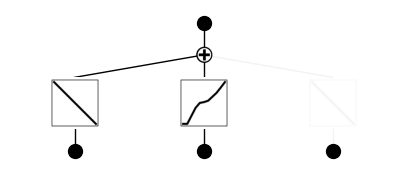

In [8]:
# Устанавливаем параметры для модели KAN
grid = 10  # Размер сетки
steps = 1  # Количество шагов обучения
k = 3      # Параметр k для метода

# Определяем архитектуру модели через список 'width', где
# первый элемент - размер входного слоя, второй - выходного
width = [3, 1]

# Создаем экземпляр модели KAN с заданными параметрами
model = KAN(width=width, grid=grid, k=k)

# Обучаем модель, используя алгоритм оптимизации LBFGS и заданное количество шагов
history = model.fit(dataset_for_KAN, opt="LBFGS", steps=steps)

# Делаем предсказания на тестовой выборке, округляем и переводим в numpy
prediction = model(torch.tensor(np.array(xtest)).float()).flatten().round().detach().numpy()

# Выводим метрики точности и F1 для оценки качества модели
print(f'Accuracy: {metrics.accuracy_score(ytest, prediction)}')
print(f'f1: {metrics.f1_score(ytest, prediction)}')

# Строим график обучения (опционально, если реализован в модели KAN)
model.plot()
plt.show()


fixing (0,0,0) with x, r2=1.0000011920928955, c=1
fixing (0,1,0) with x, r2=0.9863037467002869, c=1
fixing (0,2,0) with x, r2=1.0000014305114746, c=1
saving model version 0.2


| train_loss: 6.97e-02 | test_loss: 6.99e-02 | reg: 0.00e+00 | : 100%|█| 4/4 [00:38<00:00,  9.73s/it


saving model version 0.3
Accuracy: 0.9997184816778492
f1: 0.9961429673437902


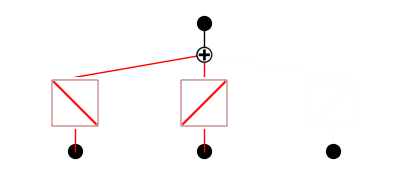

In [9]:
# Определяем библиотеку символических функций для модели KAN,
# включающую полиномы, экспоненту, логарифм, корень, гиперболический тангенс, синус и модуль
lib = ['x', 'x^2', 'x^3', 'x^4', 'exp', 'log', 'sqrt', 'tanh', 'sin', 'abs']

# Настраиваем модель KAN для автоматического выбора символических функций из заданной библиотеки
model.auto_symbolic(lib=lib)

# Повторно обучаем модель с обновленной библиотекой функций, используя алгоритм LBFGS и 4 шага обучения
history2 = model.fit(dataset_for_KAN, opt="LBFGS", steps=4)

# Делаем предсказания на тестовой выборке, округляем и переводим в numpy
prediction = model(torch.tensor(np.array(xtest)).float()).flatten().round().detach().numpy()

# Выводим метрики точности и F1 для оценки качества модели после использования библиотеки функций
print(f'Accuracy: {metrics.accuracy_score(ytest, prediction)}')
print(f'f1: {metrics.f1_score(ytest, prediction)}')

# Строим график обучения для визуализации процесса (если функция реализована в KAN)
model.plot()
plt.show()


In [10]:
# Импортируем функцию округления ex_round из утилит KAN
from kan.utils import ex_round

# Получаем символическую формулу модели и округляем ее до 5 знаков после запятой
ex_round(model.symbolic_formula()[0][0], 5)


-0.95351*x_1 + 1.87707*x_2 + 0.01017*x_3 - 0.01378

In [11]:
def predict(df):
    # Преобразуем признак 'gndr' в бинарный формат: 1 для мужчин ('м'), 0 для женщин
    df['gndr'] = df['gndr'].apply(lambda x: 1 if x == 'м' else 0)
    
    # Создаем бинарный признак 'north' для выделения северных регионов
    df['north'] = df['rgn'].apply(lambda x: 1 if x in [
        'САХА /ЯКУТИЯ/ РЕСП', 'ЧУКОТСКИЙ АО', 'ЯМАЛО-НЕНЕЦКИЙ АО',
        'НЕНЕЦКИЙ АО', 'МУРМАНСКАЯ ОБЛ', 'КАМЧАТСКИЙ КРАЙ', 'ЧУКОТСКИЙ АО'
    ] else 0)
    
    # Рассчитываем предсказание на основе символической формулы модели KAN
    # Нормализуем 'pnsn_age', вычитая 55 и деля на 10 для соответствия обучающим данным
    df['predict'] = np.round(
        -0.95338 * df['gndr'] + 
        1.87692 * ((df['pnsn_age'] - 55) / 10) + 
        0.00818 * df['north'] - 
        0.01382
    ).astype(int)
    
    # Возвращаем DataFrame с идентификатором клиента и предсказанием
    return df[['clnt_id', 'predict']]


In [12]:
# Загружаем данные из CSV-файла с указанием кодировки 'ptcp154' и разделителя ';'
df = pd.read_csv('data/cntrbtrs_clnts_ops_trn.csv', encoding='ptcp154', sep=';')


C:\Users\Arthu\AppData\Local\Temp\ipykernel_14680\501274830.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('npf\\cntrbtrs_clnts_ops_trn.csv',encoding='ptcp154',sep=';')


In [13]:
# Вызываем функцию predict для получения предсказаний
predict(df)


,clnt_id,predict
0,0x03ED62E56DAEA24B96D6F1252D713286,0
1,0x15138C4A822F1C45A819FCBE6657B810,0
2,0x943D2C768A4FB38311E659ACF7E960C3,0
3,0x9CAE18EC4F30054C83C6C78FF70D124A,0
4,0xCB416F5FE5D58E41822B4E9A5209747F,0
...,...,...
532820,0x4F753559542C8D42923BA0452CB27595,0
532821,0x943D2C768A4FB38311E65BA1D3F4228C,0
532822,0x35F03CB3F4E2564C88D8C511C3E2B999,0
532823,0x1F9C3E2874FDCB43A6C8B5930C8C2C0E,0
